## IdeiA Análise de Crédito - Machine Learning - PI DSM 6 2024/1

**PI DSM6-2024/1**

**Grupo Armazém de Ideias**

**Marcelo Luiz Siqueira Reis**

**João Paulo Cardoso Rodrigues**

**Elivelto Silva**

**IdeiA Análise de Crédito para aprovação de cartão de crédito**

**Introdução**

Uma das principais características do ser humano é ser gregário, mas nenhum grupo é autossuficiente sendo necessário o intercâmbio de objetos. E dessas trocas surgiu o comércio.

Visando otimizar as vendas o crédito passou a ser um instrumento importantíssimo para a economia.

Muito antes do surgimento do sistema econômico capitalista, já haviam as "bancas" no final da idade média que desempenhavam o papel das instituições financeiras.

Entretanto, a concessão de crédito não é algo simples ou pode ser concedida arbitrariamente, a prática já demonstrou que critérios devem ser observados na análise de crédito.

O setor financeiro estabeleceu pontuações durante a análise de crédito para prever a probabilidade de inadimplência de cartão de crédito e orientar a emissão deles. Essas pontuações dependem dos dados pessoais e informações históricas dos solicitantes, de modo a quantificar objetivamente o risco.

Neste contexto é o presente projeto para criar um modelo classificador de machine learning para ajudar os bancos a decidir quem deve obter um cartão de crédito.

##Carregando os dados

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# importando bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import joblib
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , classification_report, f1_score, precision_score, recall_score

Trabalhando com o conjunto de dados application_record.csv

In [40]:
#importando o arquivo
df_application = pd.read_csv('/content/application_record.csv', sep=',')
df_application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00
1,5008805,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00
2,5008806,M,Y,Y,0,112500.00,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.00
3,5008808,F,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00
4,5008809,F,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00


In [41]:
# conhecendo o conjunto de dados (application_record)

print(f'O conjunto de dados application_record.csv possui {df_application.shape[0]} linhas','\n')

print(f'O conjunto de dados application_recordo.csv possui {df_application.shape[1]} colunas')

O conjunto de dados application_record.csv possui 438557 linhas 

O conjunto de dados application_recordo.csv possui 18 colunas


In [42]:
#verificando datatypes
df_application.dtypes

ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
dtype: object

Conforme se observa o conjunto de dados application_record.csv possui 8 (oito) colunas/atributos object datatype (categóricos) e 10 (dez) colunas/atributos numeric datatype (numéricos).

Agora vamos verificar o conjunto de dados credit_record.csv

In [43]:
#importando o arquivo
df_credit = pd.read_csv('/content/credit_record.csv', sep=',')
df_credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [44]:
# conhecendo o conjunto de dados (credit_record)

print(f'O conjunto de dados credit_record.csv possui {df_credit.shape[0]} linhas','\n')

print(f'O conjunto de dados credit_record.csv possui {df_credit.shape[1]} colunas')

O conjunto de dados credit_record.csv possui 1048575 linhas 

O conjunto de dados credit_record.csv possui 3 colunas


In [45]:
#verificando datatypes
df_credit.dtypes

ID                 int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object

Conforme se observa o conjunto de dados credit_record.csv possui 1 (uma) coluna/atributo object datatype (categórico) e 2 (duas) colunas/atributos numeric datatype (numéricos).

**Merging (mesclando) os dois conjuntos de dados com base na coluna comum ID**

Nós mesclamos os dois dataframes com base na coluna ID presente em ambos os conjuntos de dados.
Além disso, verifica-se que o conjunto de dados credit_record.csv tem mais registros de clientes do que o conjunto de dados application_record.csv, então se faz necessário garantr que o novo dataframe (df_merge) contenha apenas as linhas que têm o mesmo número de ID
Para esse propósito, usamos o parâmetro inner na função pd.merge

In [46]:
# Merging (mesclando) os dois conjuntos de dados com base no ID

df_merge = pd.merge(df_application, df_credit, on='ID' , how='inner')

**Visualizando o conjunto de dados mesclado (merged)**

In [47]:
df_merge.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00,0,C
1,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00,-1,C
2,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00,-2,C
3,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00,-3,C
4,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00,-4,C


In [48]:
# conhecendo o novo conjunto de dados mesclado (application_record.csv + credit_record.csv)

print(f'O novo conjunto de dados mesclado (df_merge) possui {df_merge.shape[0]} linhas','\n')

print(f'O novo conjunto de dados mesclado (df_merge) possui {df_merge.shape[1]} colunas')

O novo conjunto de dados mesclado (df_merge) possui 777715 linhas 

O novo conjunto de dados mesclado (df_merge) possui 20 colunas


"""**Entendo a base**

ID: Número do cliente

CODE_GENDER: Sexo

FLAG_OWN_CAR: Possui carro

FLAG_OWN_REALTY: Possui imóvel

CNT_CHILDREN: Número de filhos

AMT_INCOME_TOTAL: Renda anual

NAME_INCOME_TYPE: Tipo de renda

NAME_EDUCATION_TYPE: Grau de escolaridade

NAME_FAMILY_STATUS: Estado civil

NAME_HOUSING_TYPE: Tipo de Moradia

DAYS_BIRTH: Aniversário em dias. Atenção: Contagem regressiva a partir do dia atual (0), -1 significa ontem

DAYS_EMPLOYED: Data de início do emprego. Atenção: Contagem regressiva a partir do dia atual (0). Se positivo, significa que a pessoa está desempregada no momento.

FLAG_MOBIL: Possui telefone celular

FLAG_WORK_PHONE: Possui telefone comercial

FLAG_PHONE: Possui telefone fixo

FLAG_EMAIL: Possui e-mail

OCCUPATION_TYPE: Tipo de ocupação

CNT_FAM_MEMBERS: Tamanho da família

MONTHS_BALANCE: Mês do registro dos dados. Atenção: O mês dos dados extraídos é o ponto de partida, para trás, 0 é o mês atual, -1 é o mês anterior e assim por diante

STATUS: Status. Atenção: 0: 1-29 dias em atraso 1: 30-59 dias em atraso 2: 60-89 dias em atraso 3: 90-119 dias em atraso 4: 120-149 dias em atraso 5: Dívidas vencidas ou incobráveis, baixas por mais de 150 dias C: quitado naquele mês X: Nenhum empréstimo no mês


**Verificando valores ausentes**

In [49]:
# verificando valores nulos
df_merge.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        240048
CNT_FAM_MEMBERS             0
MONTHS_BALANCE              0
STATUS                      0
dtype: int64

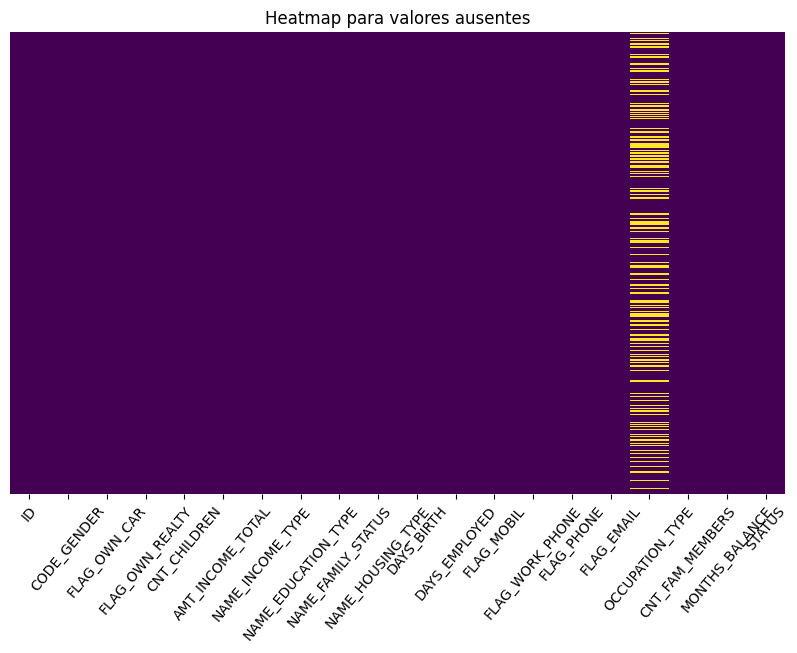

In [50]:
# plotando heatmap para verificar valores nulos

# definindo o tamanho da figura
plt.figure(figsize=(10, 6))

# plotando heatmap de valores ausentes
sns.heatmap(df_merge.isna(), cbar=False , yticklabels=False, cmap='viridis')

# definindo o título
plt.title('Heatmap para valores ausentes')
plt.xticks(rotation=50)
plt.show()

In [51]:
# verificação da porcentagem de valores ausentes na coluna/atributo `OCCUPATION_TYPE`

df_merge['OCCUPATION_TYPE'].isna().sum() / df_merge.shape[0] * 100

30.86580559716606

Analisando o novo conjunto de dados mesclado verifica-se que há apenas uma coluna*atributo que tem valores nulos.

Esta coluna/atributo é OCCUPATION_TYPE e tem 240048 valores ausentes o que corresponde a uma porcentagem de 30,86% de valores ausentes.

Ante o exposto, a opção é remover a coluna/atributo OCCUPATION_TYPE porque ela tem uma alta porcentagem de valores ausentes e como cada pessoa tem seu registro exclusivo, não se pode imputar valores para os ausentes.

In [52]:
# excluindo a coluna/atributo OCCUPATION_TYPE
df_merge.drop('OCCUPATION_TYPE', axis=1, inplace=True)

In [53]:
# verificando o resultado
df_merge.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'STATUS'],
      dtype='object')

In [54]:
# verificando a contagem de valores exclusivos em cada coluna/atributo
df_merge.nunique()

ID                     36457
CODE_GENDER                2
FLAG_OWN_CAR               2
FLAG_OWN_REALTY            2
CNT_CHILDREN               9
AMT_INCOME_TOTAL         265
NAME_INCOME_TYPE           5
NAME_EDUCATION_TYPE        5
NAME_FAMILY_STATUS         5
NAME_HOUSING_TYPE          6
DAYS_BIRTH              7183
DAYS_EMPLOYED           3640
FLAG_MOBIL                 1
FLAG_WORK_PHONE            2
FLAG_PHONE                 2
FLAG_EMAIL                 2
CNT_FAM_MEMBERS           10
MONTHS_BALANCE            61
STATUS                     8
dtype: int64

In [55]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   777715 non-null  int64  
 1   CODE_GENDER          777715 non-null  object 
 2   FLAG_OWN_CAR         777715 non-null  object 
 3   FLAG_OWN_REALTY      777715 non-null  object 
 4   CNT_CHILDREN         777715 non-null  int64  
 5   AMT_INCOME_TOTAL     777715 non-null  float64
 6   NAME_INCOME_TYPE     777715 non-null  object 
 7   NAME_EDUCATION_TYPE  777715 non-null  object 
 8   NAME_FAMILY_STATUS   777715 non-null  object 
 9   NAME_HOUSING_TYPE    777715 non-null  object 
 10  DAYS_BIRTH           777715 non-null  int64  
 11  DAYS_EMPLOYED        777715 non-null  int64  
 12  FLAG_MOBIL           777715 non-null  int64  
 13  FLAG_WORK_PHONE      777715 non-null  int64  
 14  FLAG_PHONE           777715 non-null  int64  
 15  FLAG_EMAIL       

**Atenção**

Embora o novo conjunto de dados mesclado tenha 777715 linhas, constata-se que a coluna/atributo ID possui apenas 36457 valores únicos, o que demonstra ser um indicativo de que pode haver valores duplicados no conjunto de dados.

**Tratamento de dados redundantes**

In [56]:
# verificando valores duplicados
df_merge.duplicated().sum()

0

In [57]:
df_merge[df_merge['ID'].duplicated()].head(20)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
1,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.00,-1,C
2,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.00,-2,C
3,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.00,-3,C
4,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.00,-4,C
5,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.00,-5,C
6,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.00,-6,C
7,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.00,-7,C
8,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.00,-8,C
9,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.00,-9,C
10,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.00,-10,C


In [58]:
df_merge[df_merge['ID'].duplicated()].tail(20)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
777694,5150049,F,N,Y,0,283500.00,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.00,-3,0
777695,5150049,F,N,Y,0,283500.00,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.00,-4,0
777696,5150049,F,N,Y,0,283500.00,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.00,-5,0
777697,5150049,F,N,Y,0,283500.00,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.00,-6,0
777698,5150049,F,N,Y,0,283500.00,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.00,-7,0
777699,5150049,F,N,Y,0,283500.00,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.00,-8,0
777700,5150049,F,N,Y,0,283500.00,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.00,-9,0
777702,5150337,M,N,Y,0,112500.00,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,1.00,-1,0
777703,5150337,M,N,Y,0,112500.00,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,1.00,-2,0
777704,5150337,M,N,Y,0,112500.00,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,1.00,-3,0


Apesar do conjunto de dados possuir 36457 clientes identificados pela coluna/atributo ID, verifica-se que não há duplicatas, tendo em vista que os dados são coletaados com base em diferentes meses, consoante coluna/atributo MONTHS_BALANCE

**Renomeando as colunas**

Para uma melhor visualização se faz necessário renomear as colunas para palavras em português

In [59]:
# verificando as colunas
df_merge.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'STATUS'],
      dtype='object')

In [60]:
# renomeando as colunas para ter sentido em português

df_merge.rename(columns={
    'CODE_GENDER': 'genero',
    'FLAG_OWN_CAR': 'carro_proprio',
    'FLAG_OWN_REALTY': 'casa_propria',
    'CNT_CHILDREN': 'filhos',
    'AMT_INCOME_TOTAL': 'renda',
    'NAME_INCOME_TYPE': 'tipo_de_renda',
    'NAME_EDUCATION_TYPE': 'grau_de_escolaridade',
    'NAME_FAMILY_STATUS': 'estado_civil',
    'NAME_HOUSING_TYPE': 'tipo_de_moradia',
    'FLAG_MOBIL': 'celular',
    'FLAG_WORK_PHONE': 'telefone_trabalho',
    'FLAG_PHONE': 'telefone',
    'FLAG_EMAIL': 'email',
    'CNT_FAM_MEMBERS': 'membros_da_familia',
    'MONTHS_BALANCE': 'saldo_meses',
    'STATUS' : 'status',
    'DAYS_BIRTH' : 'idade_em_dias',
    'DAYS_EMPLOYED' : 'dias_empregado'

} , inplace=True)

In [61]:
df_merge.columns

Index(['ID', 'genero', 'carro_proprio', 'casa_propria', 'filhos', 'renda',
       'tipo_de_renda', 'grau_de_escolaridade', 'estado_civil',
       'tipo_de_moradia', 'idade_em_dias', 'dias_empregado', 'celular',
       'telefone_trabalho', 'telefone', 'email', 'membros_da_familia',
       'saldo_meses', 'status'],
      dtype='object')

In [62]:
# verificando colunas object dtype

df_merge.select_dtypes(include='object').columns

Index(['genero', 'carro_proprio', 'casa_propria', 'tipo_de_renda',
       'grau_de_escolaridade', 'estado_civil', 'tipo_de_moradia', 'status'],
      dtype='object')

In [63]:
# verificando valores únicos em algumas colunas

col = ['genero', 'carro_proprio', 'casa_propria']

for i in col:
    print(f'{df_merge[i].value_counts()}')

genero
F    518851
M    258864
Name: count, dtype: int64
carro_proprio
N    473355
Y    304360
Name: count, dtype: int64
casa_propria
Y    512948
N    264767
Name: count, dtype: int64


In [64]:
# mapeando os valores em algumas colunas


# mapeando entradas únicas de gênero
df_merge['genero'] = df_merge['genero'].map({'F':'feminino', 'M': 'masculino'})

# mapeando entradas únicas de carro_proprio
df_merge['carro_proprio'] = df_merge['carro_proprio'].map({'N': 'nao', 'Y': 'sim'})

# mapeando entradas únicas de casa_propria
df_merge['casa_propria'] = df_merge['casa_propria'].map({'N': 'nao', 'Y': 'sim'})

In [65]:
# mapeando entradas únicas de tipo de renda
df_merge['tipo_de_renda'] = df_merge['tipo_de_renda'].map({'Working':'trabalhando',
                                                           'Commercial associate': 'representante comercial',
                                                           'Pensioner': 'aposentado',
                                                           'State servant': 'funcionario publico',
                                                           'Student': 'estudante'})

In [67]:
# mapeando entradas únicas de grau de escolaridade
df_merge['grau_de_escolaridade'] = df_merge['grau_de_escolaridade'].map({'Secondary / secondary special':'ensino medio / tecnico',
                                                           'Higher education': 'ensino superior',
                                                           'Incomplete higher': 'superior incompleto',
                                                           'Lower secondary': 'ensino medio incompleto',
                                                           'Academic degree': 'tecnologo'})

In [69]:
# mapeando entradas únicas de estado civil
df_merge['estado_civil'] = df_merge['estado_civil'].map({'Married': 'casado',
                                                         'Civil marriage': 'casado',
                                                         'Single / not married': 'solteiro',
                                                         'Separated': 'divorciado',
                                                         'Widow': 'viuvo'})

In [72]:
# mapeando entradas únicas de tipo de moradia
df_merge['tipo_de_moradia'] = df_merge['tipo_de_moradia'].map({'House / apartment':'imovel proprio',
                                                           'With parents': 'mora com os pais',
                                                           'Municipal apartment': 'imovel financiado',
                                                           'Rented apartment': 'imovel alugado',
                                                           'Office apartment': 'imovel comercial',
                                                           'Co-op apartment': 'imovel compartilhado'})

In [79]:
# Criando faixa etaria para utilizarmos no modelo preditivo
bins = [-36500, -21900, -18250, -14600, -10950, -7665, -1]
labels = ['Acima de 60 Anos', 'De 51 ate 60 Anos', 'De 41 ate 50 Anos', 'De 31 ate 40 Anos', 'De 22 ate 30 Anos', 'Ate 21 Anos'] # Adjusted labels to match the new bin order
df_merge['faixa_etaria'] = pd.cut(df_merge['idade_em_dias'], bins=bins, labels=labels)
df_merge.groupby(['faixa_etaria']).size()

faixa_etaria
Acima de 60 Anos      82120
De 51 ate 60 Anos    175030
De 41 ate 50 Anos    207117
De 31 ate 40 Anos    223580
De 22 ate 30 Anos     89867
Ate 21 Anos               1
dtype: int64

In [80]:
# Criando renda anual para utilizarmos no modelo preditivo
bins = [-100, 500000, 650000, 800000, 950000, 1100000, 1250000, 1400000, 5000000]
labels = ['Ate 500k', 'De 500k ate 650k', 'De 650k ate 800k', 'De 800k ate 950k', 'De 950k ate 1100k',
          'De 1100k ate 1250k', 'De 1250k ate 1400k', 'De 1400k ate 5000k']
df_merge['renda_anual'] = pd.cut(df_merge['renda'], bins=bins, labels=labels)
df_merge.groupby(['renda_anual']).size()

renda_anual
Ate 500k              767686
De 500k ate 650k        4947
De 650k ate 800k        3512
De 800k ate 950k        1209
De 950k ate 1100k         26
De 1100k ate 1250k        83
De 1250k ate 1400k       102
De 1400k ate 5000k       150
dtype: int64

In [81]:
# Criando tempo emprego para utilizarmos no modelo preditivo
bins = [-20000, -14600, -10950, -7300, -3650, -1825, -1, 500000]
labels = ['Acima de 40 Anos', 'De 31 ate 40 Anos', 'De 21 ate 30 Anos', 'De 11 ate 20 Anos', 'De 6 ate 10 Anos', 'Ate 5 Anos', 'Desempregado']
df_merge['tempo_emprego'] = pd.cut(df_merge['dias_empregado'], bins=bins, labels=labels)
df_merge.groupby(['tempo_emprego']).size()

tempo_emprego
Acima de 40 Anos       1268
De 31 ate 40 Anos      6493
De 21 ate 30 Anos     33189
De 11 ate 20 Anos    124598
De 6 ate 10 Anos     201440
Ate 5 Anos           282755
Desempregado         127972
dtype: int64

In [82]:
# Criando tempo registro dos dados para utilizarmos no modelo preditivo
bins = [-100, -48, -36, -24, -12, -1, 100000]
labels = ['Acima de 48 Meses', 'De 36 ate 47 Meses', 'De 24 ate 35 Meses', 'De 13 ate 23 Meses', 'De 1 ate 12 Meses', 'Nenhum mes']
df_merge['tempo_registro_dados'] = pd.cut(df_merge['saldo_meses'], bins=bins, labels=labels)
df_merge.groupby(['tempo_registro_dados']).size()

tempo_registro_dados
Acima de 48 Meses      31082
De 36 ate 47 Meses     89870
De 24 ate 35 Meses    154664
De 13 ate 23 Meses    220633
De 1 ate 12 Meses     256794
Nenhum mes             24672
dtype: int64

In [83]:
# verificando valores únicos na coluna status

df_merge['status'].value_counts()

status
C    329536
0    290654
X    145950
1      8747
5      1527
2       801
3       286
4       214
Name: count, dtype: int64

In [84]:
# mapeando os valores na coluna status e armazenando o resultado na nova coluna status_do_emprestimo

df_merge['status_do_emprestimo'] = df_merge['status'].map({'0': 'Reprovado',
                                                           '1': 'Reprovado',
                                                           '2': 'Reprovado',
                                                           '3': 'Reprovado',
                                                           '4': 'Reprovado',
                                                           '5': 'Reprovado',
                                                           'C': 'Aprovado',
                                                           'X' : 'Aprovado'})

In [85]:
df_merge.status_do_emprestimo.value_counts()

status_do_emprestimo
Aprovado     475486
Reprovado    302229
Name: count, dtype: int64

In [86]:
# confirmando o resultado

df_merge.columns.values

array(['ID', 'genero', 'carro_proprio', 'casa_propria', 'filhos', 'renda',
       'tipo_de_renda', 'grau_de_escolaridade', 'estado_civil',
       'tipo_de_moradia', 'idade_em_dias', 'dias_empregado', 'celular',
       'telefone_trabalho', 'telefone', 'email', 'membros_da_familia',
       'saldo_meses', 'status', 'faixa_etaria', 'renda_anual',
       'tempo_emprego', 'tempo_registro_dados', 'status_do_emprestimo'],
      dtype=object)

In [87]:
# Criação de novo conjunto de dados
columns = ['ID', 'genero', 'carro_proprio', 'casa_propria', 'filhos', 'tipo_de_renda', 'grau_de_escolaridade',
           'estado_civil', 'tipo_de_moradia', 'celular', 'telefone_trabalho', 'telefone', 'email', 'membros_da_familia',
           'faixa_etaria', 'renda_anual', 'tempo_emprego', 'tempo_registro_dados', 'status_do_emprestimo']

df_juntado = pd.DataFrame(df_merge, columns=columns)

In [88]:
df_juntado.to_csv('application_credit_record_v5.csv', index=False)

Prosseguindo com a análise exploratória de dados, o principal objetivo é analisar os diferentes atributos dos clientes, a distribuição dos dados, o relacionamento entre os atributos e em especial obter uma visão geral do relacionamento entre os atributos e a classe (variável de destino) status_do_emprestimo.

**Verificando a distribuição de 'genero', 'carro_proprio', 'casa_propria'**

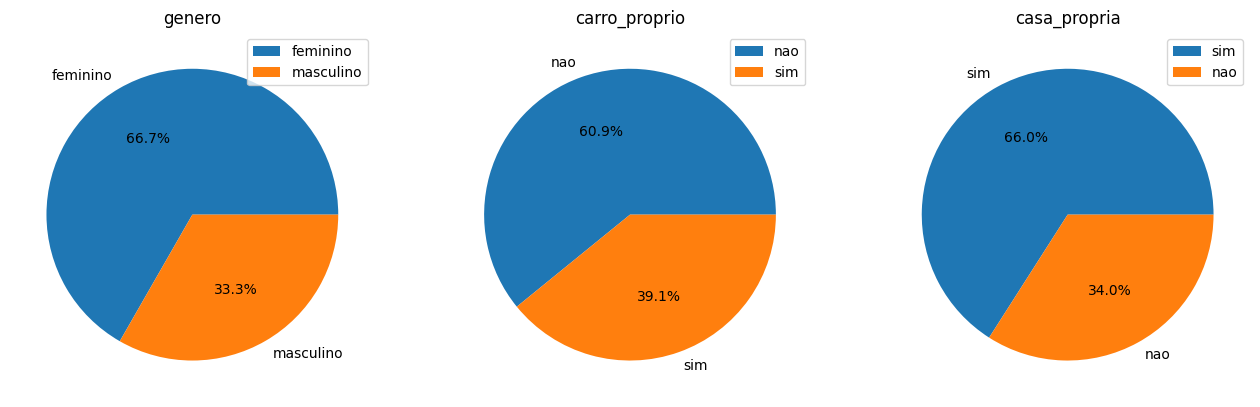

In [89]:
# Definir a lista de nomes de colunas
columns = ['genero', 'carro_proprio', 'casa_propria']

# Criar subplots para cada coluna
plt.figure(figsize=(16 , 9))  # Ajustar o tamanho da figura conforme necessário

for i in range(len(columns)):
    plt.subplot(1, 3, i+1)
    plt.title(columns[i])  # Usar o nome da coluna como título

    # Plotar gráfico pizza
    counts = df_merge[columns[i]].value_counts()
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%'  )

    # Adicionar legendas com valores exclusivos
    plt.legend(counts.index)
plt.show()

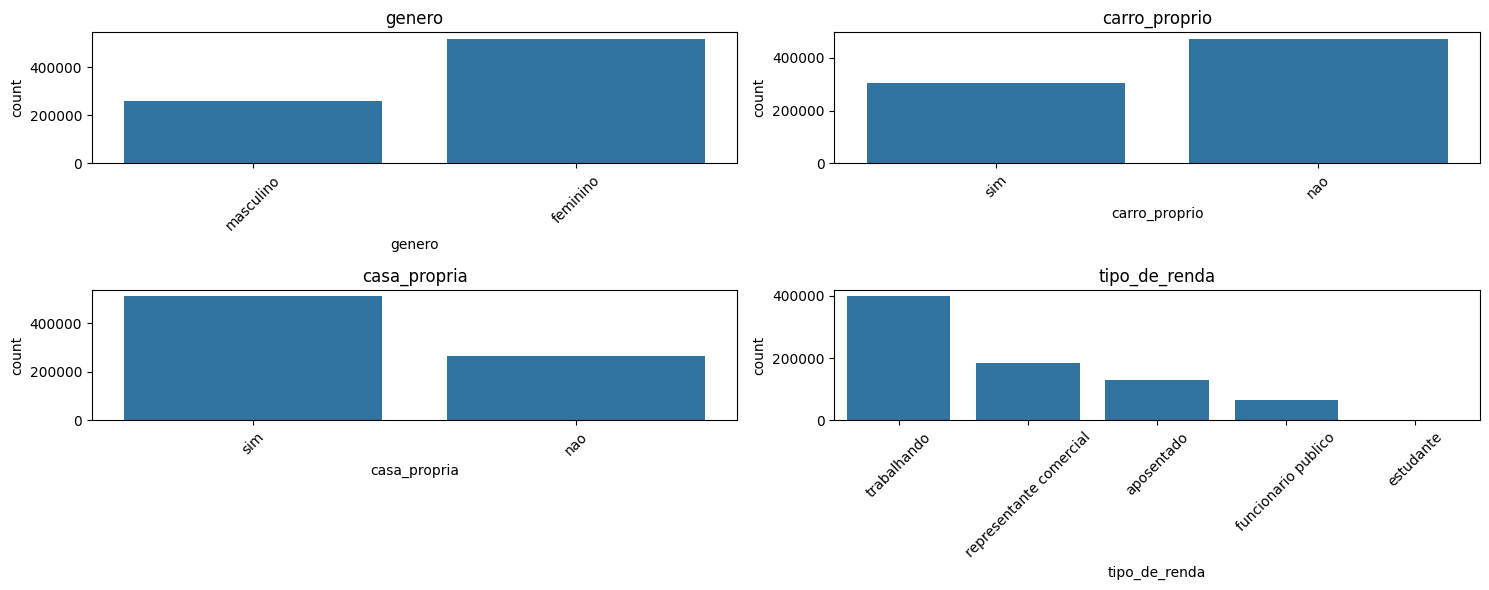

In [90]:
# criando lista de colunas específicas
col = ['genero', 'carro_proprio', 'casa_propria', 'tipo_de_renda',]

# definindo o tamnanho da figura
plt.figure(figsize=(15, 6))

# plotando o countplot usando loop for
for i in range(len(col)):
    # definindo o subplot
    plt.subplot(2, 2, i+1)
    # adicionando título
    plt.title(col[i])
    # plotando o countplot
    sns.countplot(data=df_merge, x=df_merge[col[i]])
    # girando os rótulos do eixo x
    plt.xticks(rotation=45)
# ajuste de layout
plt.tight_layout()
plt.show()

Conforme se observa há mais clientes mulheres do que homens, o número de clientes que não têm carro é maior que aqueles que têm, enquanto que, os clientes com casa própria são a maioria.

In [91]:
# verificando a contagem de status_do_emprestimo

df_merge['status_do_emprestimo'].value_counts()

status_do_emprestimo
Aprovado     475486
Reprovado    302229
Name: count, dtype: int64

**Obtendo insights do 'status_do_emprestimo' X 'genero'**

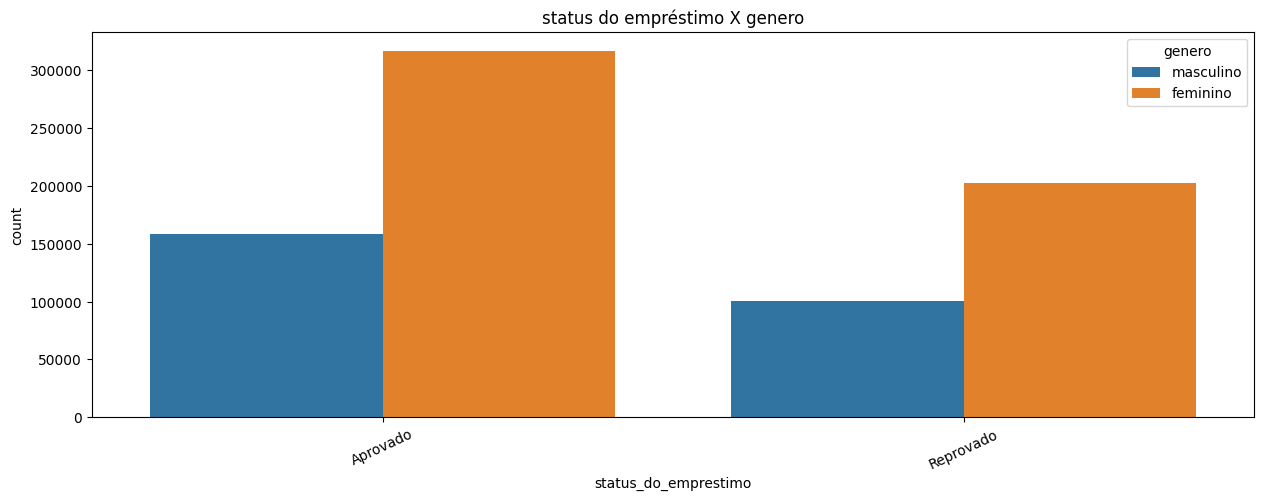

In [92]:
# verificando a relação entre o status do empréstimo e o gênero

# definindo o tamanho da figura
plt.figure(figsize=(15, 5))

# plotando o countplot (gráfico de contagem)
sns.countplot(data=df_merge, x=df_merge['status_do_emprestimo'], hue=df_merge['genero'])

# definindo o título
plt.title('status do empréstimo X genero')
# girando os rótulos do eixo x
plt.xticks(rotation=25)
plt.show()


In [93]:
# obtendo insights do status do empréstimo X gênero
df_merge.columns # obtendo os nomes exatos das colunas

Index(['ID', 'genero', 'carro_proprio', 'casa_propria', 'filhos', 'renda',
       'tipo_de_renda', 'grau_de_escolaridade', 'estado_civil',
       'tipo_de_moradia', 'idade_em_dias', 'dias_empregado', 'celular',
       'telefone_trabalho', 'telefone', 'email', 'membros_da_familia',
       'saldo_meses', 'status', 'faixa_etaria', 'renda_anual', 'tempo_emprego',
       'tempo_registro_dados', 'status_do_emprestimo'],
      dtype='object')

In [94]:
# verificando a contagem de valores do tipo de renda

df_merge['tipo_de_renda'].value_counts()

tipo_de_renda
trabalhando                400164
representante comercial    183385
aposentado                 128392
funcionario publico         65437
estudante                     337
Name: count, dtype: int64

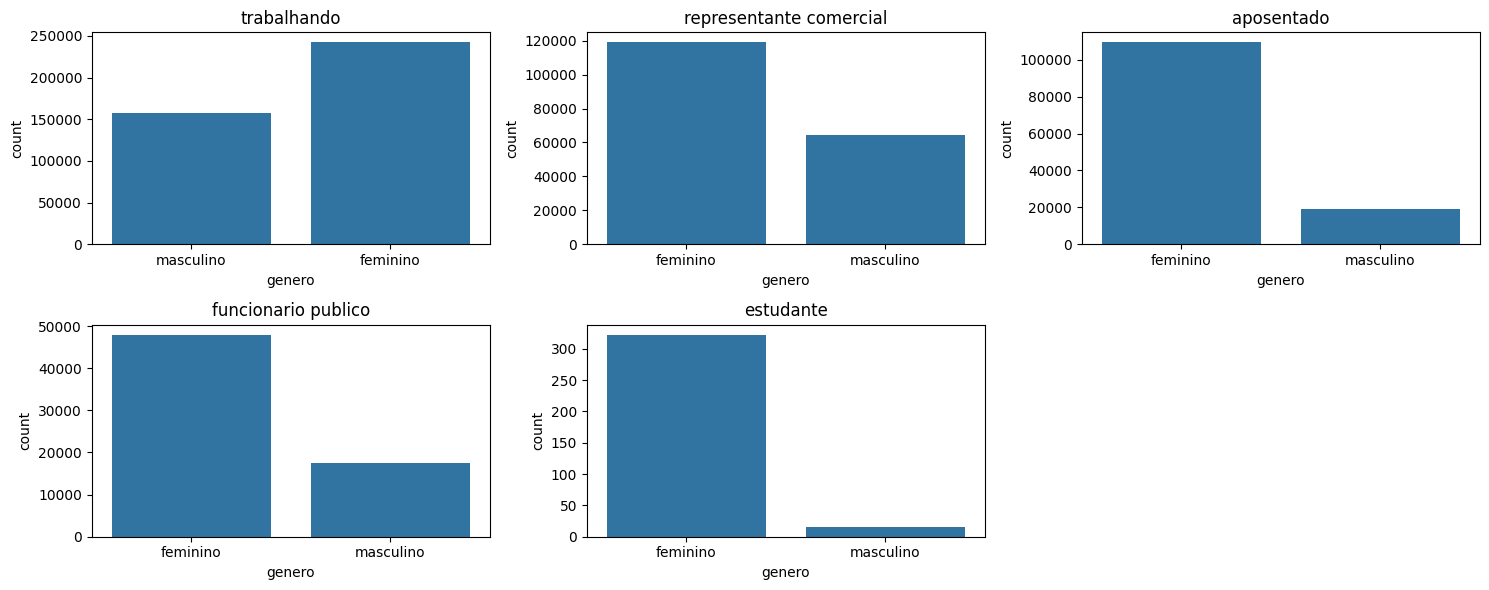

In [95]:
# verificando a relação entre o tipo de renda e o gênero

count = df_merge['tipo_de_renda'].value_counts()

plt.figure(figsize=(15, 6))

# Plotando o countplot (gráfico de contagem) para cada valor único de 'tipo_de_renda'
for i in range(len(count)):
    plt.subplot(2, 3, i+1)
    plt.title(count.index[i])  # Use o valor único do 'tipo_de_renda' como valor único
    sns.countplot(data=df_merge[df_merge['tipo_de_renda'] == count.index[i]], x='genero')

plt.tight_layout()  # Ajuste o layout para evitar sobreposição
plt.show()

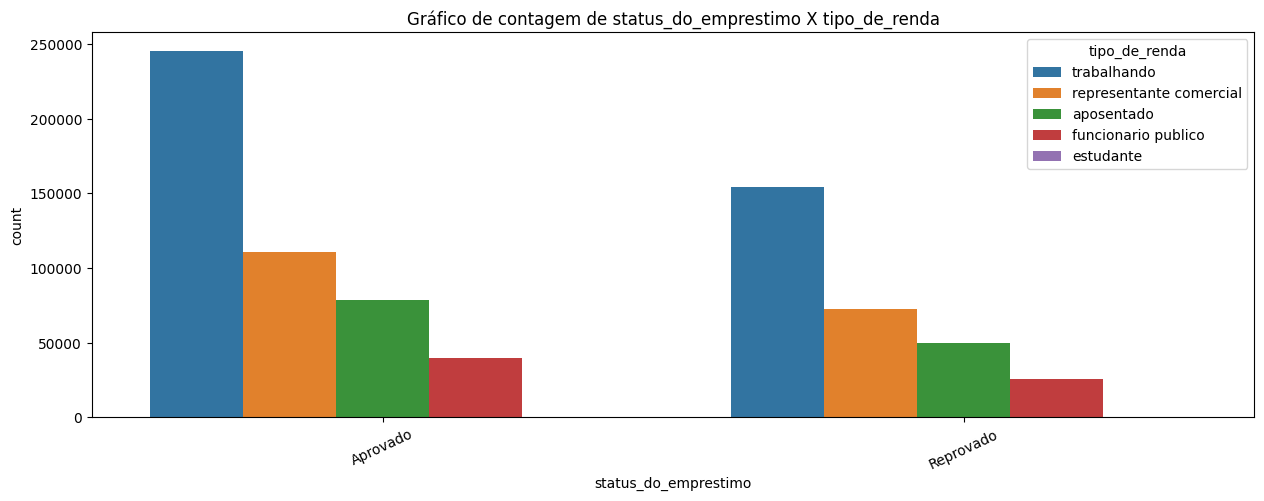

In [96]:
# verificando a relação entre status do empréstimo e tipo de renda

# definindo o tamanho da figura
plt.figure(figsize=(15, 5))

# plotando o countplot (gráfico de contagem)
sns.countplot(data=df_merge, x=df_merge['status_do_emprestimo'], hue=df_merge['tipo_de_renda'])

# definindo o título
plt.title('Gráfico de contagem de status_do_emprestimo X tipo_de_renda')
plt.xticks(rotation=25)
plt.show()

In [97]:
# obtendo insights de gênero X tipo de renda e status do empréstimo com contagens de valores menores que 1000
count = df_merge.groupby('genero')[['tipo_de_renda', 'status_do_emprestimo']].value_counts()

count[count<1000].unstack()

,status_do_emprestimo,Aprovado,Reprovado
genero,tipo_de_renda,,
feminino,estudante,265,57
masculino,estudante,4,11


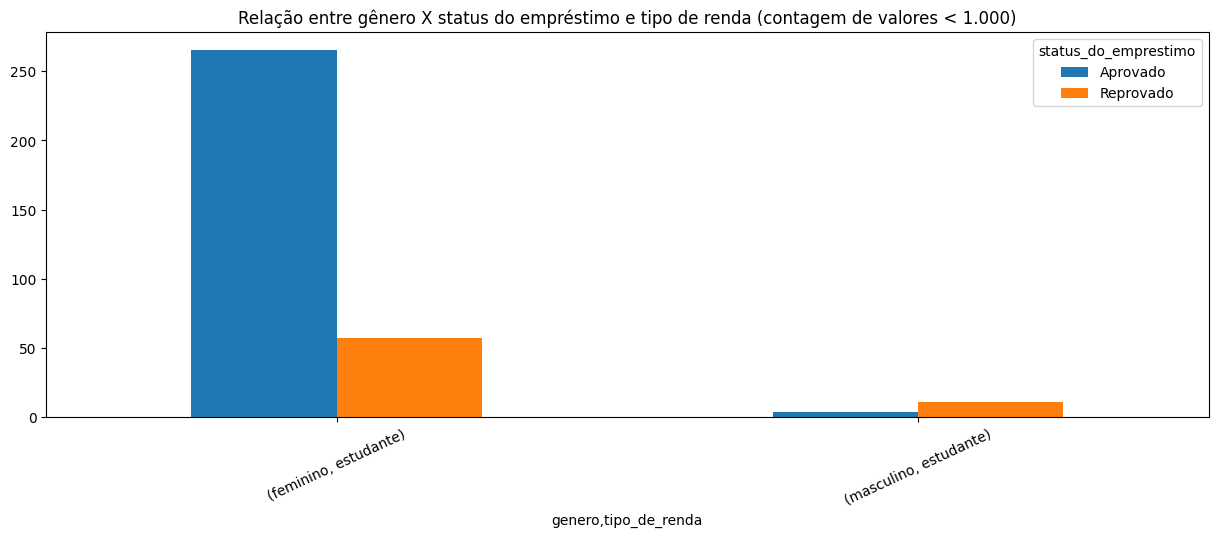

In [98]:
# verificando a relação entre gênero X tipo de renda e status do empréstimo
count = df_merge.groupby('genero')[['tipo_de_renda', 'status_do_emprestimo' ]].value_counts()

# plotando o gráfico de barh para contagem de valores (genero X tipo de renda e status do emprestimo) menor que 1.000
count[count<1000].unstack().plot(kind='bar' , figsize=(15, 5) , legend=True )
# definindo o título
plt.title('Relação entre gênero X status do empréstimo e tipo de renda (contagem de valores < 1.000)')
# girando os rótulos do eixo x
plt.xticks(rotation=25)
plt.show()

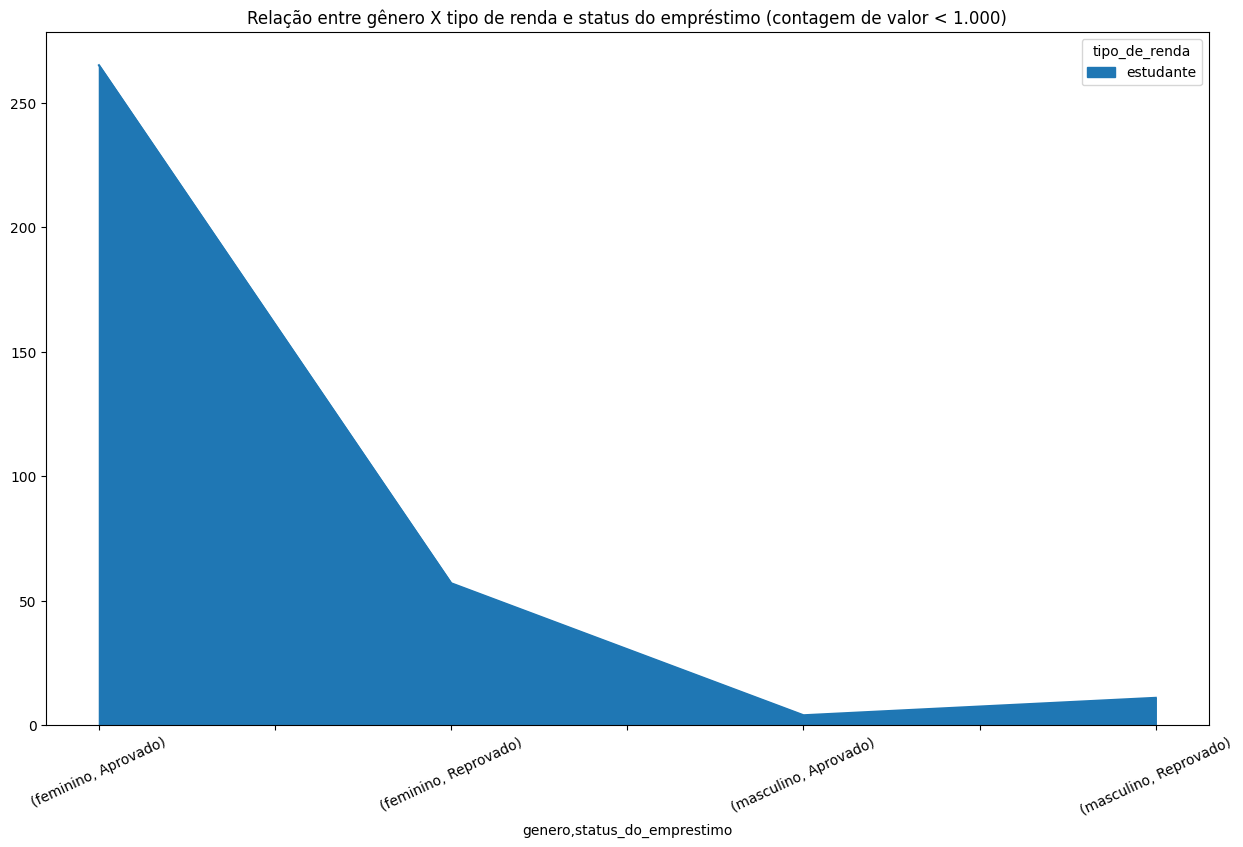

In [99]:
# gráfico de área da relação entre gênero X tipo de renda e status do empréstimo com contagens de valores menores que 1.000
# verificando a relação entre gênero X tipo de renda e status do empréstimo
count = df_merge.groupby('genero')[['status_do_emprestimo','tipo_de_renda']].value_counts()
# plotando o gráfico de área para (gênero X tipo de renda e status do empréstimo) contagem de valores menores que 1.000
count[count<1000].unstack().plot(kind='area' , figsize=(15, 9))
# definindo o título
plt.title('Relação entre gênero X tipo de renda e status do empréstimo (contagem de valor < 1.000)')
# girando os rótulos do eixo x
plt.xticks(rotation=25)
plt.show()

In [100]:
# verificando a contagem de valores da educação
df_merge.grau_de_escolaridade.value_counts()

grau_de_escolaridade
ensino medio / tecnico     524261
ensino superior            213633
superior incompleto         30329
ensino medio incompleto      8655
tecnologo                     837
Name: count, dtype: int64

In [101]:
# verificando a relação entre gênero e educação
df_merge.groupby('genero')[['grau_de_escolaridade']].value_counts()

genero     grau_de_escolaridade   
feminino   ensino medio / tecnico     349975
           ensino superior            144457
           superior incompleto         18638
           ensino medio incompleto      5177
           tecnologo                     604
masculino  ensino medio / tecnico     174286
           ensino superior             69176
           superior incompleto         11691
           ensino medio incompleto      3478
           tecnologo                     233
Name: count, dtype: int64

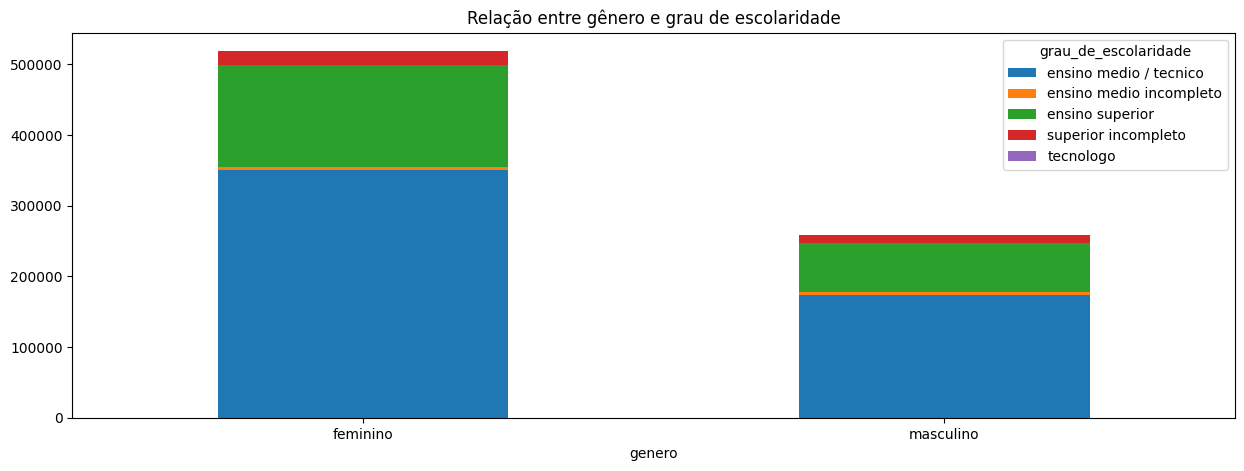

In [102]:
# plotando o countplot para grau de escolaridade X gênero
df_merge.groupby('genero')[['grau_de_escolaridade']].value_counts().unstack().plot(kind='bar', figsize=(15, 5) , stacked=True)

# girando os rótulos do eixo x
plt.xticks(rotation=360)

# definindo o título
plt.title('Relação entre gênero e grau de escolaridade')
plt.show()

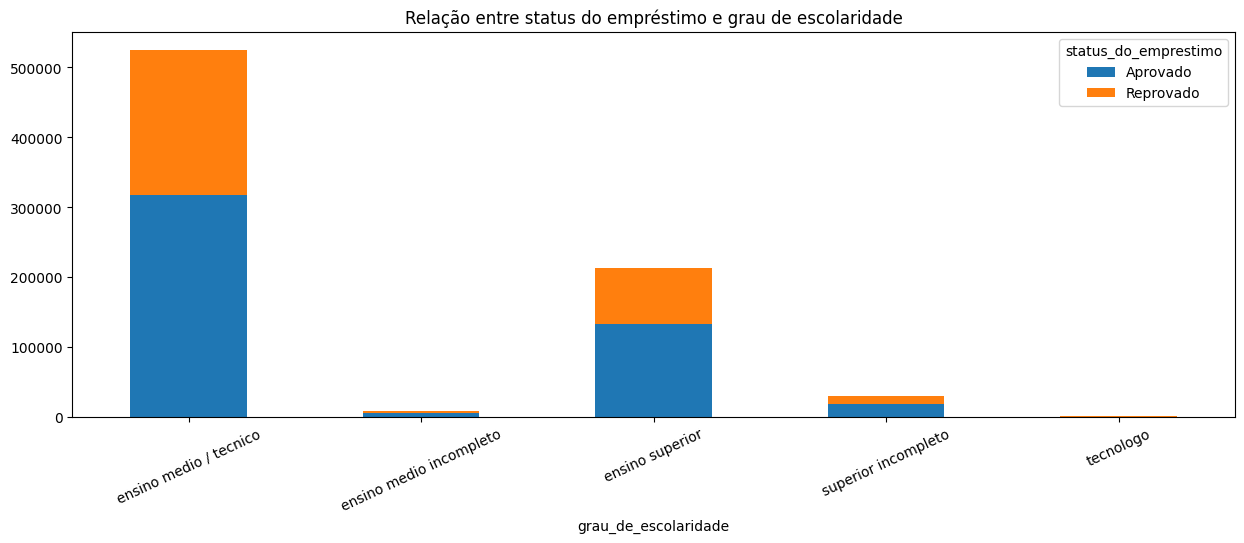

In [103]:
# verificando a relação entre status do empréstimo e grau de escolaridade usando a função groupby
df_merge.groupby('grau_de_escolaridade')[['status_do_emprestimo']].value_counts().unstack().plot(kind='bar', figsize=(15, 5) , stacked= True)
# definindo o título
plt.title('Relação entre status do empréstimo e grau de escolaridade')
# girando os rótulos do eixo x
plt.xticks(rotation=25)
plt.show()

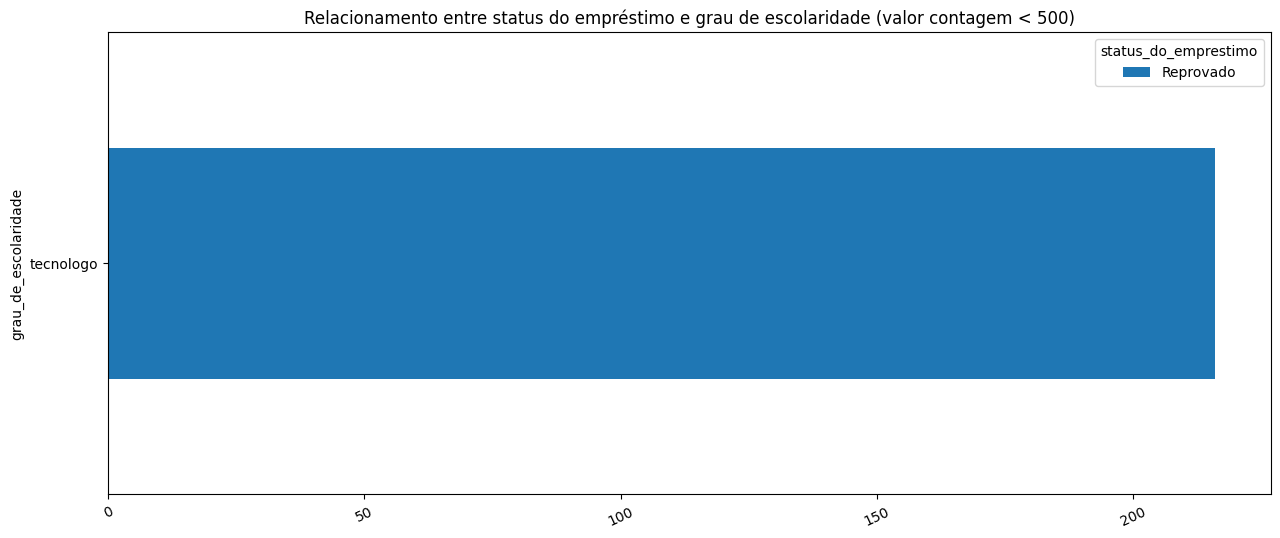

In [104]:
# verificando a relação entre status do empréstimo e grau de escolaridade
count = df_merge.groupby('grau_de_escolaridade')[['status_do_emprestimo']].value_counts()

# plotando o gráfico de barh para grau de escolaridade X status do empréstimo que têm valores menores que 500
count[count<=500].unstack().plot(kind='barh' , figsize=(15, 6))
# definindo o título
plt.title('Relacionamento entre status do empréstimo e grau de escolaridade (valor contagem < 500)')
# girando os rótulos do eixo x
plt.xticks(rotation=25)
plt.show()

In [105]:
# verificando as entradas unique da coluna tipo de moradia

df_merge['tipo_de_moradia'].unique()

array(['imovel alugado', 'imovel proprio', 'imovel financiado',
       'mora com os pais', 'imovel compartilhado', 'imovel comercial'],
      dtype=object)

In [106]:
# verificando contagens de valores da coluna tipo de moradia
df_merge['tipo_de_moradia'].value_counts()

tipo_de_moradia
imovel proprio          697151
mora com os pais         35735
imovel financiado        24640
imovel alugado           10898
imovel comercial          5636
imovel compartilhado      3655
Name: count, dtype: int64

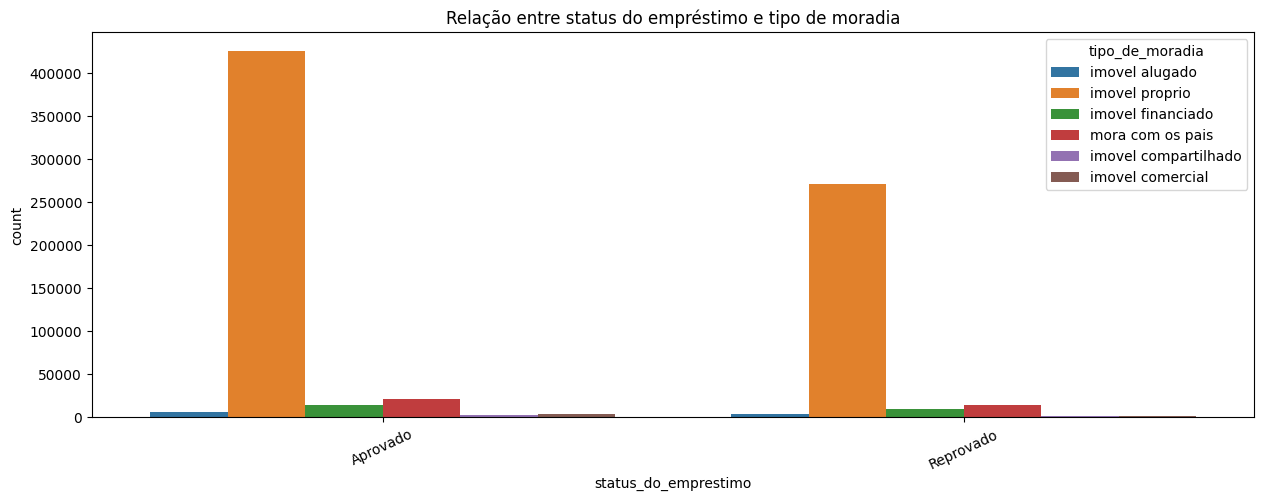

In [107]:
# verificando a relação entre status do empréstimo e tipo de moradia

# definindo o tamanho da figura
plt.figure(figsize=(15, 5))

# plotando o countplot
sns.countplot(data=df_merge, x=df_merge['status_do_emprestimo'], hue=df_merge['tipo_de_moradia'])

plt.xticks(rotation=25)
plt.title('Relação entre status do empréstimo e tipo de moradia')

plt.show()

In [108]:
# verificando a relação entre status do empréstimo e tipo de moradia

# agrupar por tipo de moradia e status do empréstimo para obter suas contagens
count = df_merge.groupby(['tipo_de_moradia', 'status_do_emprestimo']).size()

# Obter contagens de valor onde status do empréstimo é divida ruim
emprestimo_ruim= count[count.index.get_level_values('status_do_emprestimo') == 'Reprovado']
emprestimo_ruim

tipo_de_moradia       status_do_emprestimo
imovel alugado        Reprovado                 4290
imovel comercial      Reprovado                 2131
imovel compartilhado  Reprovado                 1247
imovel financiado     Reprovado                 9748
imovel proprio        Reprovado               270854
mora com os pais      Reprovado                13959
dtype: int64

In [109]:
# verificando os nomes das colunas
df_merge.columns

Index(['ID', 'genero', 'carro_proprio', 'casa_propria', 'filhos', 'renda',
       'tipo_de_renda', 'grau_de_escolaridade', 'estado_civil',
       'tipo_de_moradia', 'idade_em_dias', 'dias_empregado', 'celular',
       'telefone_trabalho', 'telefone', 'email', 'membros_da_familia',
       'saldo_meses', 'status', 'faixa_etaria', 'renda_anual', 'tempo_emprego',
       'tempo_registro_dados', 'status_do_emprestimo'],
      dtype='object')

In [110]:
# verificando a contagem dos valores da coluna membros_da_familia
df_merge.membros_da_familia.value_counts()

membros_da_familia
2.00     423723
1.00     141477
3.00     134894
4.00      66990
5.00       8999
6.00       1196
7.00        273
15.00       111
9.00         46
20.00         6
Name: count, dtype: int64

In [111]:
# verificando o relacionamento entre status do empréstimo e membros da família
df_merge.groupby('membros_da_familia')[['status_do_emprestimo']].value_counts().unstack()

status_do_emprestimo,Aprovado,Reprovado
membros_da_familia,,
1.00,85874.00,55603.00
2.00,260269.00,163454.00
3.00,81900.00,52994.00
4.00,40843.00,26147.00
5.00,5626.00,3373.00
6.00,712.00,484.00
7.00,216.00,57.00
9.00,22.00,24.00
15.00,24.00,87.00


In [112]:
df_merge.select_dtypes(exclude='object').columns # verificando o nome das colunas com numeric datatype

Index(['ID', 'filhos', 'renda', 'idade_em_dias', 'dias_empregado', 'celular',
       'telefone_trabalho', 'telefone', 'email', 'membros_da_familia',
       'saldo_meses', 'faixa_etaria', 'renda_anual', 'tempo_emprego',
       'tempo_registro_dados'],
      dtype='object')

In [113]:
# verificando a contagem de valores de filhos
df_merge.filhos.value_counts()

filhos
0     540639
1     155638
2      70399
3       9328
4       1224
5        324
14       111
7         46
19         6
Name: count, dtype: int64

In [114]:
# verificando a relação entre status do empréstimo e filhos

df_merge.groupby('filhos')[['status_do_emprestimo']].value_counts().unstack()

status_do_emprestimo,Aprovado,Reprovado
filhos,,
0,331025.00,209614.00
1,94600.00,61038.00
2,43147.00,27252.00
3,5710.00,3618.00
4,713.00,511.00
5,245.00,79.00
7,22.00,24.00
14,24.00,87.00
19,NaN,6.00


In [115]:
df_merge.isnull().sum()

ID                      0
genero                  0
carro_proprio           0
casa_propria            0
filhos                  0
renda                   0
tipo_de_renda           0
grau_de_escolaridade    0
estado_civil            0
tipo_de_moradia         0
idade_em_dias           0
dias_empregado          0
celular                 0
telefone_trabalho       0
telefone                0
email                   0
membros_da_familia      0
saldo_meses             0
status                  0
faixa_etaria            0
renda_anual             0
tempo_emprego           0
tempo_registro_dados    0
status_do_emprestimo    0
dtype: int64

In [118]:
# filtrar dataframe onde dias empregado > 0
df_merge.tempo_emprego.value_counts()

tempo_emprego
Ate 5 Anos           282755
De 6 ate 10 Anos     201440
Desempregado         127972
De 11 ate 20 Anos    124598
De 21 ate 30 Anos     33189
De 31 ate 40 Anos      6493
Acima de 40 Anos       1268
Name: count, dtype: int64

No conjunto de dados há 127972 pessoas desempregadas.

##Pré-processamento

In [119]:
# informar o nome das colunas
df_merge.columns

Index(['ID', 'genero', 'carro_proprio', 'casa_propria', 'filhos', 'renda',
       'tipo_de_renda', 'grau_de_escolaridade', 'estado_civil',
       'tipo_de_moradia', 'idade_em_dias', 'dias_empregado', 'celular',
       'telefone_trabalho', 'telefone', 'email', 'membros_da_familia',
       'saldo_meses', 'status', 'faixa_etaria', 'renda_anual', 'tempo_emprego',
       'tempo_registro_dados', 'status_do_emprestimo'],
      dtype='object')

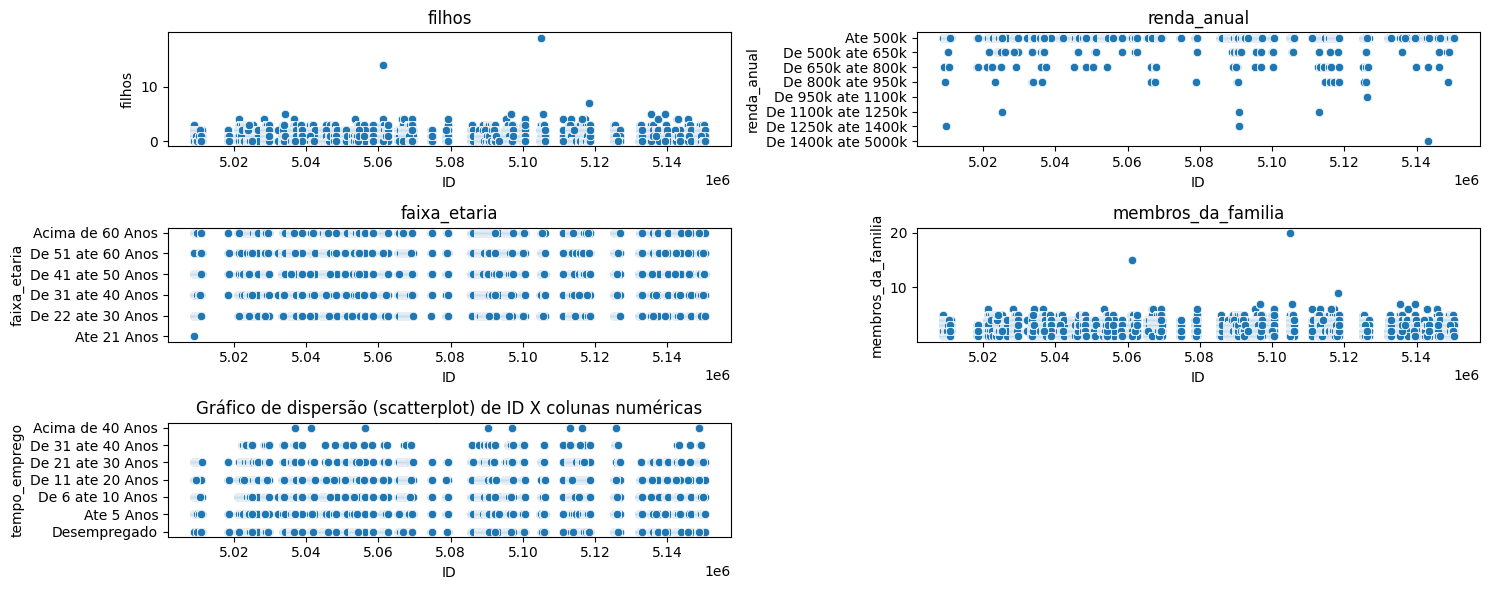

In [120]:
# plotando o gráfico de dispersão de colunas numéricas
# verificando a relação entre status do empréstimo e renda
col = ['filhos', 'renda_anual', 'faixa_etaria',  'membros_da_familia' , 'tempo_emprego']

# definindo o tamanho da figura
plt.figure(figsize=(15, 6))

# plotando o countplot usando o loop for
for i in range(len(col)):
    plt.subplot(3, 2, i+1)
    plt.title(col[i])  # Usar o nome da coluna como título
    sns.scatterplot(data=df_merge, y=col[i], x='ID')
plt.title('Gráfico de dispersão (scatterplot) de ID X colunas numéricas')
plt.tight_layout()  # Ajuste o layout para evitar sobreposição
plt.show()

In [121]:
df_merge.columns

Index(['ID', 'genero', 'carro_proprio', 'casa_propria', 'filhos', 'renda',
       'tipo_de_renda', 'grau_de_escolaridade', 'estado_civil',
       'tipo_de_moradia', 'idade_em_dias', 'dias_empregado', 'celular',
       'telefone_trabalho', 'telefone', 'email', 'membros_da_familia',
       'saldo_meses', 'status', 'faixa_etaria', 'renda_anual', 'tempo_emprego',
       'tempo_registro_dados', 'status_do_emprestimo'],
      dtype='object')

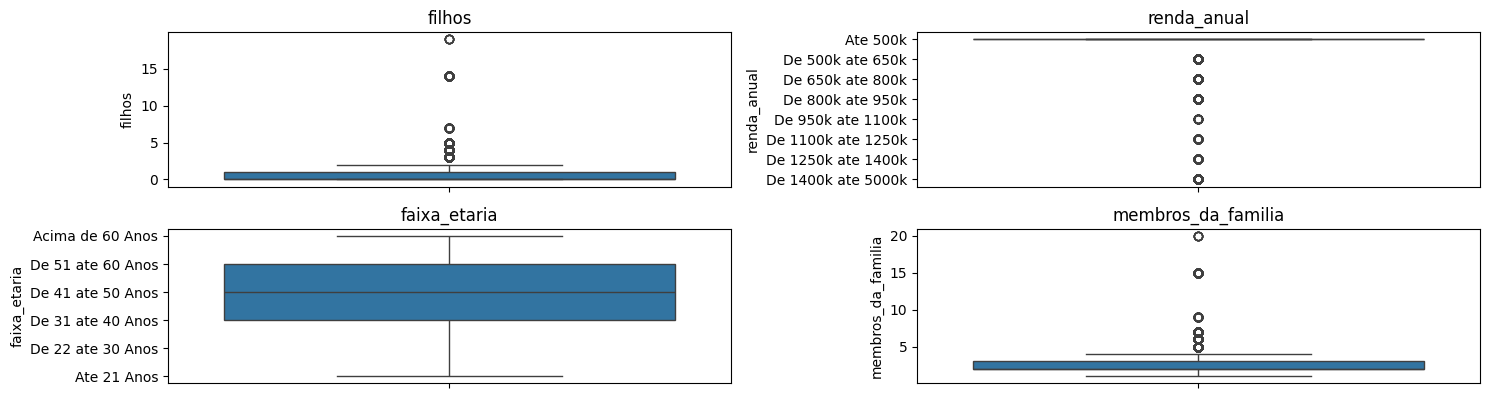

In [123]:
# plotando o boxplot de colunas nunéricas
# verificando a relação entre status do empréstimo e renda

# filtrando a lista de colunas específicas
col = ['filhos', 'renda_anual', 'faixa_etaria',  'membros_da_familia' ]

# definindo o tamanho da figura
plt.figure(figsize=(15, 6))

# plotando o countplot usando o loop for
for i in range(len(col)):
    plt.subplot(3, 2, i+1)
    plt.title(col[i])  # Use o nome da coluna como título
    sns.boxplot(data=df_merge, y=col[i])

plt.tight_layout()  # Ajuste o layout para evitar sobreposição
plt.show()

Verifica-se que os outliers estão presentes em duas colunas: filhos, membros_da_familia. Tanto o gráfico de dispersão quanto o gráfico de caixa estão mostrando outliers nas colunas supra mencionadas.

**Remoção de outliers**

In [125]:
# removendo outliers

# filtrando a lista de colunas específicas
col = ['filhos', 'membros_da_familia']

# loop para remover outliers
for i in range(len(col)):
    # calculando o primeiro e o terceiro quartil
    q1 = df_merge[col[i]].quantile(0.25)
    q3 = df_merge[col[i]].quantile(0.75)
    # calculando o intervalo interquartil
    iqr = q3 - q1
    # calculando os limites inferior e superior
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # substituindo os outliers pela mediana
    df_merge[col[i]] = np.where((df_merge[col[i]] >= upper_bound) | (df_merge[col[i]] <= lower_bound), df_merge[col[i]].median() , df_merge[col[i]])

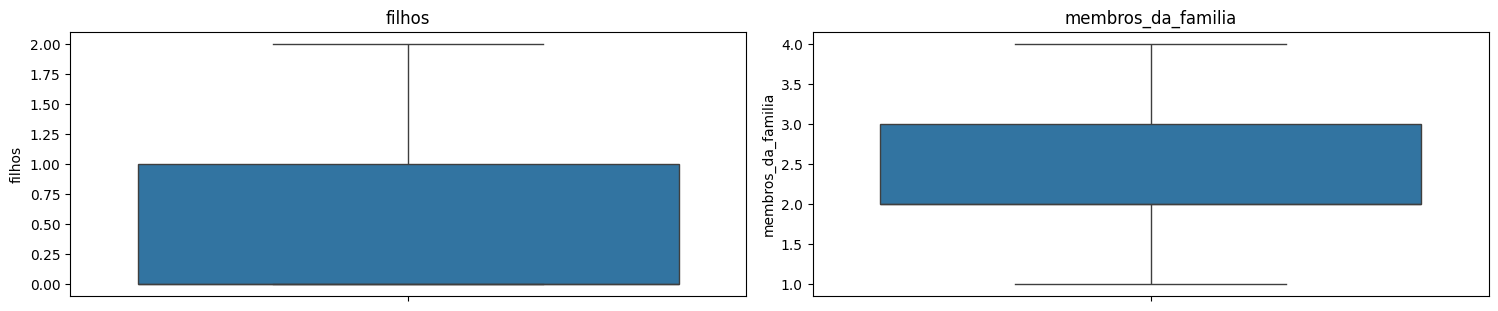

In [126]:
# plotando o bocplot novamente para confirmar os resultados
col = ['filhos', 'membros_da_familia']

plt.figure(figsize=(15, 6))

for i in range(len(col)):
    plt.subplot(2, 2, i+1)
    plt.title(col[i])  # Use o nome da coluna como título
    sns.boxplot(data=df_merge, y=col[i])

plt.tight_layout()  # Ajuste o layout para evitar sobreposição
plt.show()

In [127]:
df_merge.isnull().sum()

ID                      0
genero                  0
carro_proprio           0
casa_propria            0
filhos                  0
renda                   0
tipo_de_renda           0
grau_de_escolaridade    0
estado_civil            0
tipo_de_moradia         0
idade_em_dias           0
dias_empregado          0
celular                 0
telefone_trabalho       0
telefone                0
email                   0
membros_da_familia      0
saldo_meses             0
status                  0
faixa_etaria            0
renda_anual             0
tempo_emprego           0
tempo_registro_dados    0
status_do_emprestimo    0
dtype: int64

In [128]:
df_merge.columns

Index(['ID', 'genero', 'carro_proprio', 'casa_propria', 'filhos', 'renda',
       'tipo_de_renda', 'grau_de_escolaridade', 'estado_civil',
       'tipo_de_moradia', 'idade_em_dias', 'dias_empregado', 'celular',
       'telefone_trabalho', 'telefone', 'email', 'membros_da_familia',
       'saldo_meses', 'status', 'faixa_etaria', 'renda_anual', 'tempo_emprego',
       'tempo_registro_dados', 'status_do_emprestimo'],
      dtype='object')

In [129]:
df_merge.select_dtypes(exclude='object').columns

Index(['ID', 'filhos', 'renda', 'idade_em_dias', 'dias_empregado', 'celular',
       'telefone_trabalho', 'telefone', 'email', 'membros_da_familia',
       'saldo_meses', 'faixa_etaria', 'renda_anual', 'tempo_emprego',
       'tempo_registro_dados'],
      dtype='object')

In [130]:
df_dados = df_juntado

In [131]:
df_dados.isnull().sum()

ID                      0
genero                  0
carro_proprio           0
casa_propria            0
filhos                  0
tipo_de_renda           0
grau_de_escolaridade    0
estado_civil            0
tipo_de_moradia         0
celular                 0
telefone_trabalho       0
telefone                0
email                   0
membros_da_familia      0
faixa_etaria            0
renda_anual             0
tempo_emprego           0
tempo_registro_dados    0
status_do_emprestimo    0
dtype: int64

In [132]:
df_dados.genero.value_counts()

genero
feminino     518851
masculino    258864
Name: count, dtype: int64

In [133]:
df_dados.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   ID                    777715 non-null  int64   
 1   genero                777715 non-null  object  
 2   carro_proprio         777715 non-null  object  
 3   casa_propria          777715 non-null  object  
 4   filhos                777715 non-null  int64   
 5   tipo_de_renda         777715 non-null  object  
 6   grau_de_escolaridade  777715 non-null  object  
 7   estado_civil          777715 non-null  object  
 8   tipo_de_moradia       777715 non-null  object  
 9   celular               777715 non-null  int64   
 10  telefone_trabalho     777715 non-null  int64   
 11  telefone              777715 non-null  int64   
 12  email                 777715 non-null  int64   
 13  membros_da_familia    777715 non-null  float64 
 14  faixa_etaria          777715 non-nul

**Padronização (Standartization)**

In [134]:
# filtrando a lista de colunas específicas
col = ['filhos', 'membros_da_familia']

# chamando o escalonador padrão
sc = StandardScaler()
# loop for para escalonar as colunas específicas
for i in col:
    df_dados[i] = sc.fit_transform(df_dados[[i]])

**Adequação do modelo: Random Forest Classifier**

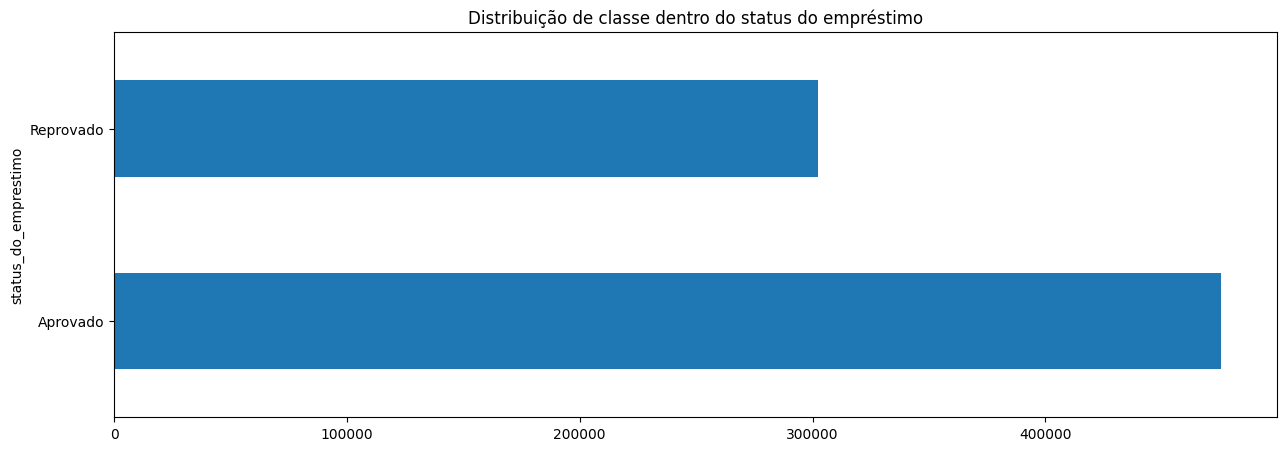

In [135]:
# verificando a distribuição de status do empréstimo
df_merge.status_do_emprestimo.value_counts().plot(kind='barh', figsize=(15, 5))
# definindo o título
plt.title('Distribuição de classe dentro do status do empréstimo')
plt.show()

O status_do_emprestimo é a classe (variável alvo). Verifica-se que a classe alvo é altamente desbalanceada. O que significa que não se pode usar regressão logística nos dados. Ante o exposto, o algoritmo Random Forest Classifier é o melhor modelo a ser utilizado.

In [136]:
df_dados.head()

,ID,genero,carro_proprio,casa_propria,filhos,tipo_de_renda,grau_de_escolaridade,estado_civil,tipo_de_moradia,celular,telefone_trabalho,telefone,email,membros_da_familia,faixa_etaria,renda_anual,tempo_emprego,tempo_registro_dados,status_do_emprestimo
0,5008804,masculino,sim,sim,-0.57,trabalhando,ensino superior,casado,imovel alugado,1,1,0,0,-0.23,De 31 ate 40 Anos,Ate 500k,De 11 ate 20 Anos,Nenhum mes,Aprovado
1,5008804,masculino,sim,sim,-0.57,trabalhando,ensino superior,casado,imovel alugado,1,1,0,0,-0.23,De 31 ate 40 Anos,Ate 500k,De 11 ate 20 Anos,De 1 ate 12 Meses,Aprovado
2,5008804,masculino,sim,sim,-0.57,trabalhando,ensino superior,casado,imovel alugado,1,1,0,0,-0.23,De 31 ate 40 Anos,Ate 500k,De 11 ate 20 Anos,De 1 ate 12 Meses,Aprovado
3,5008804,masculino,sim,sim,-0.57,trabalhando,ensino superior,casado,imovel alugado,1,1,0,0,-0.23,De 31 ate 40 Anos,Ate 500k,De 11 ate 20 Anos,De 1 ate 12 Meses,Aprovado
4,5008804,masculino,sim,sim,-0.57,trabalhando,ensino superior,casado,imovel alugado,1,1,0,0,-0.23,De 31 ate 40 Anos,Ate 500k,De 11 ate 20 Anos,De 1 ate 12 Meses,Aprovado


**Label Encoding**

A transformação de dados categóricos em númericos é parte essencial no pré-processamento, no presente projeto, analisando o conjunto de dados, a técnica escolhida é o Label Encoding.

In [137]:
# retornando os nomes das colunas
df_dados.columns

Index(['ID', 'genero', 'carro_proprio', 'casa_propria', 'filhos',
       'tipo_de_renda', 'grau_de_escolaridade', 'estado_civil',
       'tipo_de_moradia', 'celular', 'telefone_trabalho', 'telefone', 'email',
       'membros_da_familia', 'faixa_etaria', 'renda_anual', 'tempo_emprego',
       'tempo_registro_dados', 'status_do_emprestimo'],
      dtype='object')

In [138]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   ID                    777715 non-null  int64   
 1   genero                777715 non-null  object  
 2   carro_proprio         777715 non-null  object  
 3   casa_propria          777715 non-null  object  
 4   filhos                777715 non-null  float64 
 5   tipo_de_renda         777715 non-null  object  
 6   grau_de_escolaridade  777715 non-null  object  
 7   estado_civil          777715 non-null  object  
 8   tipo_de_moradia       777715 non-null  object  
 9   celular               777715 non-null  int64   
 10  telefone_trabalho     777715 non-null  int64   
 11  telefone              777715 non-null  int64   
 12  email                 777715 non-null  int64   
 13  membros_da_familia    777715 non-null  float64 
 14  faixa_etaria          777715 non-nul

In [139]:
# filtrando a lista de colunas específicas que necessitam aplicar técnica de codificar (encode)
col = ['genero', 'carro_proprio', 'casa_propria', 'tipo_de_renda','grau_de_escolaridade', 'estado_civil',
       'tipo_de_moradia', 'faixa_etaria', 'renda_anual', 'tempo_emprego', 'tempo_registro_dados']

# chamando o label encoder (codificador de rótulo)
le = LabelEncoder()

# loop for para codificar as colunas específicas
for i in col:
    df_dados[i] =le.fit_transform(df_dados[i])

In [140]:
df_dados.head()

,ID,genero,carro_proprio,casa_propria,filhos,tipo_de_renda,grau_de_escolaridade,estado_civil,tipo_de_moradia,celular,telefone_trabalho,telefone,email,membros_da_familia,faixa_etaria,renda_anual,tempo_emprego,tempo_registro_dados,status_do_emprestimo
0,5008804,1,1,1,-0.57,4,2,0,0,1,1,0,0,-0.23,3,0,2,5,Aprovado
1,5008804,1,1,1,-0.57,4,2,0,0,1,1,0,0,-0.23,3,0,2,1,Aprovado
2,5008804,1,1,1,-0.57,4,2,0,0,1,1,0,0,-0.23,3,0,2,1,Aprovado
3,5008804,1,1,1,-0.57,4,2,0,0,1,1,0,0,-0.23,3,0,2,1,Aprovado
4,5008804,1,1,1,-0.57,4,2,0,0,1,1,0,0,-0.23,3,0,2,1,Aprovado


**Verificando a Multicolinearidade**

Multicolinearidade ocorre quando duas ou mais variáveis preditoras em um modelo estão altamente correlacionadas entre si. Isso significa que uma variável pode ser prevista com uma precisão razoável a partir de outras variáveis no modelo. A multicolinearidade pode causar problemas no modelo de regressão, pois dificulta a determinação da influência individual de cada variável preditora na variável resposta. Isso pode resultar em coeficientes instáveis e imprecisos, bem como intervalos de confiança amplos.
A técnica **Variance Inflation Factor - VIF (Fator de Inflação da Variância)** é uma ferramenta usada para detectar e quantificar a multicolinearidade. O VIF para uma variável preditora específica é uma medida da inflação da variância de seu coeficiente de regressão devido à sua correlação com outras variáveis preditoras no modelo. Um VIF de 1 indica a ausência de multicolinearidade, enquanto valores maiores que 1 indicam um grau crescente de multicolinearidade. Geralmente, um VIF de 10 ou maior é considerado indicativo de um problema significativo de multicolinearidade.

In [141]:
# Remova as colunas 'status_do_emprestimo' e 'status' de col
col = df_dados.drop(['status_do_emprestimo'], axis=1) # Assuma que col é nossa variável independente

# Calcule a variance inflation factor - VIF (fator de inflação de variância)

# Crie um dataframe para armazenar o VIF
factor  = pd.DataFrame(columns=["VIF", "Features"] )
# Para cada coluna, calcule o VIF
factor["Features"] = col.columns
factor["VIF"] = [variance_inflation_factor(col.values, i) for i in range(col.shape[1])]

# Exiba os resultados
factor

,VIF,Features
0,1.02,ID
1,1.21,genero
2,1.20,carro_proprio
3,1.06,casa_propria
4,23.58,filhos
5,1.74,tipo_de_renda
6,1.04,grau_de_escolaridade
7,7.04,estado_civil
8,1.01,tipo_de_moradia
9,15121.40,celular


**Treino e teste**

In [142]:
#Dividindo o conjunto de dados em recursos e rótulos
X = df_dados.drop(['status_do_emprestimo' , 'filhos' , 'membros_da_familia', 'celular'], axis = 1)
y = df_dados['status_do_emprestimo']

In [143]:
X.columns

Index(['ID', 'genero', 'carro_proprio', 'casa_propria', 'tipo_de_renda',
       'grau_de_escolaridade', 'estado_civil', 'tipo_de_moradia',
       'telefone_trabalho', 'telefone', 'email', 'faixa_etaria', 'renda_anual',
       'tempo_emprego', 'tempo_registro_dados'],
      dtype='object')

In [144]:
X.head()

,ID,genero,carro_proprio,casa_propria,tipo_de_renda,grau_de_escolaridade,estado_civil,tipo_de_moradia,telefone_trabalho,telefone,email,faixa_etaria,renda_anual,tempo_emprego,tempo_registro_dados
0,5008804,1,1,1,4,2,0,0,1,0,0,3,0,2,5
1,5008804,1,1,1,4,2,0,0,1,0,0,3,0,2,1
2,5008804,1,1,1,4,2,0,0,1,0,0,3,0,2,1
3,5008804,1,1,1,4,2,0,0,1,0,0,3,0,2,1
4,5008804,1,1,1,4,2,0,0,1,0,0,3,0,2,1


In [145]:
print(f'O formato do X = {X.shape} \n') # verificando o formato do X
print(f'O formato do y = {y.shape}') # verificando o formato do y

O formato do X = (777715, 15) 

O formato do y = (777715,)


In [146]:
# dividindo (split) o conjunto de dados em treinamento e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.2, random_state = 42)

Utilizando o modelo Random Forest Classifier, o conjunto de dados foi dividido em 80% de treinamento e 20% de teste.

In [147]:
# instanciando o modelo
model = RandomForestClassifier()

In [148]:
# ajustando (fit) o modelo
clf = model.fit(X_treino, y_treino)

In [149]:
# fazendo previsões no conjunto de teste
y_pred = model.predict(X_teste)

In [150]:
# criando um dataframe para comparar os valores reais e previstos
pd.DataFrame({'Atual': y_teste, 'Previsto': y_pred}).head(10)

,Atual,Previsto
489996,Reprovado,Reprovado
293437,Reprovado,Reprovado
544675,Reprovado,Reprovado
688170,Aprovado,Aprovado
582519,Aprovado,Reprovado
248623,Aprovado,Aprovado
476807,Reprovado,Reprovado
693691,Aprovado,Aprovado
89611,Aprovado,Aprovado
756662,Aprovado,Aprovado


**Avaliação do modelo**

In [151]:
print(f'Accuracy Score: {accuracy_score(y_teste, y_pred) * 100:.2f}%')

Accuracy Score: 86.15%


In [152]:
print(f"Precision Score: {precision_score(y_teste, y_pred, average='micro'):.2f}")

Precision Score: 0.86


In [153]:
print(f"F1-Score: {f1_score(y_teste, y_pred, average='micro')}")

F1-Score: 0.8614916775425445


In [154]:
# relatório de classificação
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

    Aprovado       0.89      0.88      0.89     95255
   Reprovado       0.82      0.83      0.82     60288

    accuracy                           0.86    155543
   macro avg       0.85      0.86      0.85    155543
weighted avg       0.86      0.86      0.86    155543



**Conclusão**

Accuracy Score (acurácia)

Accuracy score (acurácia) é basicamente a porcentagem de previsões realizadas corretamente pelo modelo de todas as previsões (número de previsões corretas dividido pelo número total de previsões).
O valor da accuracy score (acurácia) varia entre 0 e 1 (100%)
A accuracy score (acurácia) do modelo deste projeto é de 86,15%, o que é bom.

Precision Score (precisão)

Precision score (precisão) é resumidamente a porcentagem de previsões positivas corretas feitas pelo modelo, ou seja, o número de previsões positivas corretas dividido pelo número total de previsões positivas.
O valor da precision score (precisão) varia entre 0 e 1.
O cálculo da precision score (precisão) deste modelo usou o parâmetro average = 'micro' que calcula a pontuação de precision score (precisão) globalmente considerando o número total de verdadeiros positivos, falsos positivos e falsos negativos em todas as classes. Tratando todas as instâncias (amostras) igualmente, independentemente de seus class labels (rótulos de classe).
A precision score (precisão) do modelo deste projeto é 0,86 o que indica que o número de falsos positivos é muito menor.

Recall Score

Recall é a porcentagem de previsões negativas corretas feitas pelo modelo, considerando, o número de previsões negativas corretas dividido pelo número total de previsões negativas.
O valor de recall score varia entre 0 e 1.
O recall score deste modelo é 0,86 o que indica que o número de falsos netivos é muito menor.

F1 Score

F1 score é a média harmônica de precision score (precisão e recall score.
É útil quando há classes desbalanceadas no conjunto de dados e fornece melhores resultados ao incluir precision score (precisão) e recall score.


## Deploy

import joblib

**Save the model as a pickle in a file**

joblib.dump(knn, 'filename.pkl')

***Load the model from the file ***

knn_from_joblib = joblib.load('filename.pkl')

**Use the loaded model to make predictions**

knn_from_joblib.predict(X_test)i

In [158]:
joblib.dump(clf, 'modelo_v5.pkl')

['modelo_v5.pkl']

In [159]:
clf_from_joblib = joblib.load('modelo_v5.pkl')

In [160]:
clf_from_joblib.predict(X_teste)

array(['Reprovado', 'Reprovado', 'Reprovado', ..., 'Aprovado',
       'Reprovado', 'Aprovado'], dtype=object)